In [1]:
import numpy as np 
import pandas as pd 
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/bollywood-celeb-localized-face-dataset/Bollywood_celeb_face_localized/bollywood_celeb_faces2/Sunny_Deol/Sunny_Deol.126.jpg
/kaggle/input/bollywood-celeb-localized-face-dataset/Bollywood_celeb_face_localized/bollywood_celeb_faces2/Sunny_Deol/Sunny_Deol.51.jpg
/kaggle/input/bollywood-celeb-localized-face-dataset/Bollywood_celeb_face_localized/bollywood_celeb_faces2/Sunny_Deol/Sunny_Deol.158.jpg
/kaggle/input/bollywood-celeb-localized-face-dataset/Bollywood_celeb_face_localized/bollywood_celeb_faces2/Sunny_Deol/Sunny_Deol.110.jpg
/kaggle/input/bollywood-celeb-localized-face-dataset/Bollywood_celeb_face_localized/bollywood_celeb_faces2/Sunny_Deol/Sunny_Deol.96.jpg
/kaggle/input/bollywood-celeb-localized-face-dataset/Bollywood_celeb_face_localized/bollywood_celeb_faces2/Sunny_Deol/Sunny_Deol.72.jpg
/kaggle/input/bollywood-celeb-localized-face-dataset/Bollywood_celeb_face_localized/bollywood_celeb_faces2/Sunny_Deol/Sunny_Deol.117.jpg
/kaggle/input/bollywood-celeb-localized-face

In [2]:
filenames=os.listdir('/kaggle/input/bollywood-celeb-localized-face-dataset')
subfile1='/kaggle/input/bollywood-celeb-localized-face-dataset/Bollywood_celeb_face_localized/bollywood_celeb_faces2'
subfile2='/kaggle/input/bollywood-celeb-localized-face-dataset/Bollywood_celeb_face_localized/bollywood_celeb_faces_0'
subfile3='/kaggle/input/bollywood-celeb-localized-face-dataset/Bollywood_celeb_face_localized/bollywood_celeb_faces_1'                     
filenames 

['Bollywood_celeb_face_localized']

In [16]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K

In [17]:
import tensorflow as tf

base_dir = '/kaggle/input/bollywood-celeb-localized-face-dataset'
batch_size = 32
img_size = 128

training_set = tf.keras.utils.image_dataset_from_directory(
  base_dir,
  label_mode="int",
  validation_split=0.02,
  subset="training",
  seed=100,
  image_size=(img_size, img_size),
  batch_size=batch_size)

Found 8664 files belonging to 1 classes.
Using 8491 files for training.


['Bollywood_celeb_face_localized']


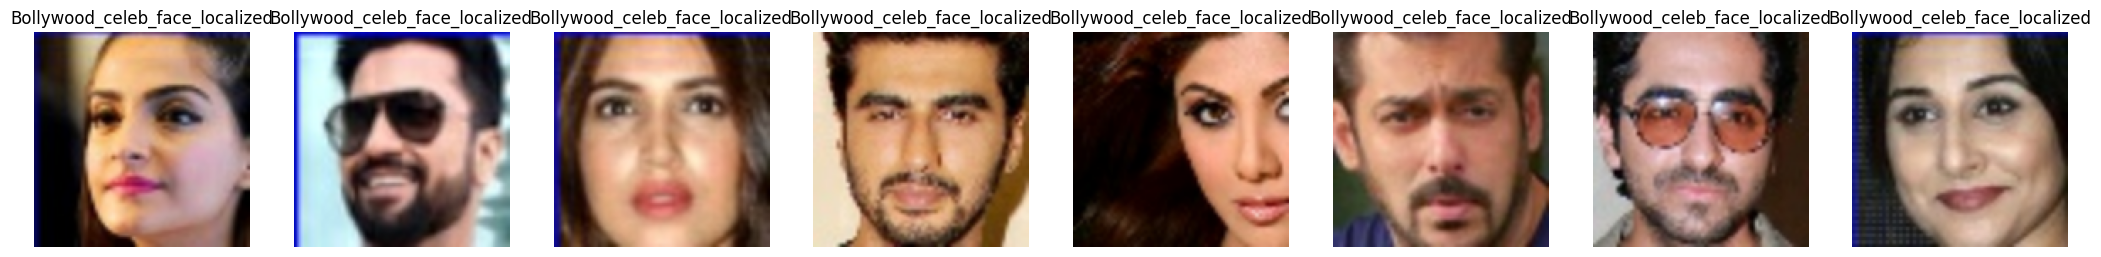

In [8]:
class_names = training_set.class_names
print(class_names)
plt.figure(figsize=(100, 100))
for images, labels in training_set.take(1):
    for i in range(8):
        ax = plt.subplot(30, 30, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [11]:
# Set random seed for reproducibility
tf.random.set_seed(42)
np.random.seed(42)

In [15]:
# Load and preprocess the dataset using ImageDataGenerator
def load_dataset(dataset_path, target_size=(64, 64), batch_size=64):
    datagen = ImageDataGenerator(rescale=1./255)
    data_generator = datagen.flow_from_directory(
        dataset_path,
        target_size=target_size,
        batch_size=batch_size,
        class_mode='input',
        shuffle=True
    )
    return data_generator

In [18]:
latent_dim = 100  # Dimensionality of the latent space

# Encoder
input_img = keras.Input(shape=(64, 64, 3))  # Assuming 64x64 RGB images
x = layers.Conv2D(32, 3, activation='relu', padding='same')(input_img)
x = layers.Conv2D(64, 3, activation='relu', padding='same', strides=2)(x)
x = layers.Conv2D(64, 3, activation='relu', padding='same')(x)
x = layers.Conv2D(64, 3, activation='relu', padding='same')(x)
x = layers.Flatten()(x)
z_mean = layers.Dense(latent_dim)(x)
z_log_var = layers.Dense(latent_dim)(x)

# Sampling layer
def sampling(args):
    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

z = layers.Lambda(sampling)([z_mean, z_log_var])

# Decoder
decoder_input = layers.Input(K.int_shape(z)[1:])
x = layers.Dense(8 * 8 * 64, activation='relu')(decoder_input)
x = layers.Reshape((8, 8, 64))(x)
x = layers.Conv2DTranspose(64, 3, activation='relu', padding='same', strides=2)(x)
x = layers.Conv2D(64, 3, activation='relu', padding='same')(x)
x = layers.Conv2D(32, 3, activation='relu', padding='same')(x)
x = layers.Conv2D(3, 3, activation='sigmoid', padding='same')(x)

# Instantiate encoder and decoder models
encoder = Model(input_img, [z_mean, z_log_var, z], name='encoder')
decoder = Model(decoder_input, x, name='decoder')

# VAE model
z_decoded = decoder(z)
vae = Model(input_img, z_decoded, name='vae')

# VAE Loss
def vae_loss(input_img, z_decoded):
    reconstruction_loss = keras.losses.binary_crossentropy(K.flatten(input_img), K.flatten(z_decoded))
    reconstruction_loss *= 64 * 64 * 3  # Assuming 64x64 RGB images
    kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
    kl_loss = K.sum(kl_loss, axis=-1)
    kl_loss *= -0.5
    vae_loss = K.mean(reconstruction_loss + kl_loss)
    return vae_loss

vae.compile(optimizer='adam', loss=vae_loss)

dataset_path = '/kaggle/input/bollywood-celeb-localized-face-dataset'
celeb_images_generator = load_dataset(dataset_path, target_size=(64, 64), batch_size=64)

# Fetch an example batch from the generator for model input shape
sample_batch, _ = next(celeb_images_generator)

input_shape = sample_batch[0].shape
print("Input shape:", input_shape)


# Train the VAE
vae.fit(celeb_images_generator, epochs=50, batch_size=32)


Found 8664 images belonging to 1 classes.
Input shape: (64, 64, 3)
Epoch 1/50


ValueError: Tried to convert 'x' to a tensor and failed. Error: A KerasTensor cannot be used as input to a TensorFlow function. A KerasTensor is a symbolic placeholder for a shape and dtype, used when constructing Keras Functional models or Keras Functions. You can only use it as input to a Keras layer or a Keras operation (from the namespaces `keras.layers` and `keras.operations`). You are likely doing something like:

```
x = Input(...)
...
tf_fn(x)  # Invalid.
```

What you should do instead is wrap `tf_fn` in a layer:

```
class MyLayer(Layer):
    def call(self, x):
        return tf_fn(x)

x = MyLayer()(x)
```
